<a href="https://colab.research.google.com/github/ABBU2712/Open-Source-Kornia/blob/main/Tutorial_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install kornia numpy matplotlib

In [2]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import torch
import kornia as K

from torchvision import datasets, transforms
from torchvision.utils import make_grid

/usr/local/lib/python3.7/dist-packages/kornia/augmentation/augmentation.py:1875: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  category=DeprecationWarning,


In [3]:
# Select runtime device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


In [4]:
%%capture
dataset = datasets.MNIST('./data/mnist', train=True, download=True, 
                         transform=transforms.Compose([transforms.ToTensor()])) 

In [5]:
images = []
for i in range(len(dataset)):
  im, _ = dataset[i]
  images.append(im) 
images = torch.stack(images, dim = 0).to(device)

In [6]:
zca = K.enhance.ZCAWhitening(eps=0.1)
images_zca = zca(images, include_fit = True)

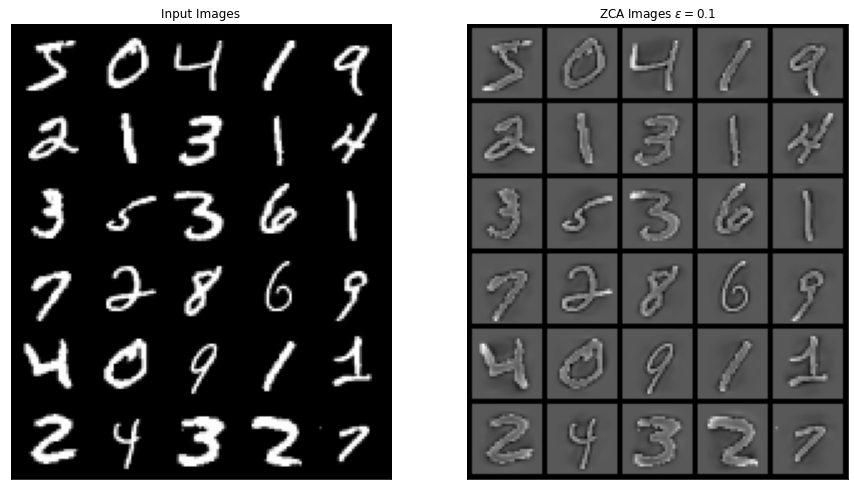

In [7]:
grid_im = make_grid(images[0:30], nrow=5, normalize=True).cpu().numpy()
grid_zca = make_grid(images_zca[0:30], nrow=5, normalize=True).cpu().numpy()


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.transpose(grid_im,[1,2,0]))
plt.title('Input Images')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(np.transpose(grid_zca,[1,2,0]))
plt.title(r'ZCA Images $\epsilon = 0.1$')
plt.xticks([])
plt.yticks([])
plt.show()

In [8]:
%%capture
dataset = datasets.CIFAR10('./data/cifar', train=True, download=True, 
                         transform=transforms.Compose([transforms.ToTensor()]))
images = []
for i in range(len(dataset)):
  im, _ = dataset[i]
  images.append(im) 
images = torch.stack(images, dim = 0).to(device) 

In [9]:
zca = K.enhance.ZCAWhitening(eps=0.1, compute_inv=True)
zca.fit(images)
zca_images = zca(images)
image_re = zca.inverse_transform(zca_images)

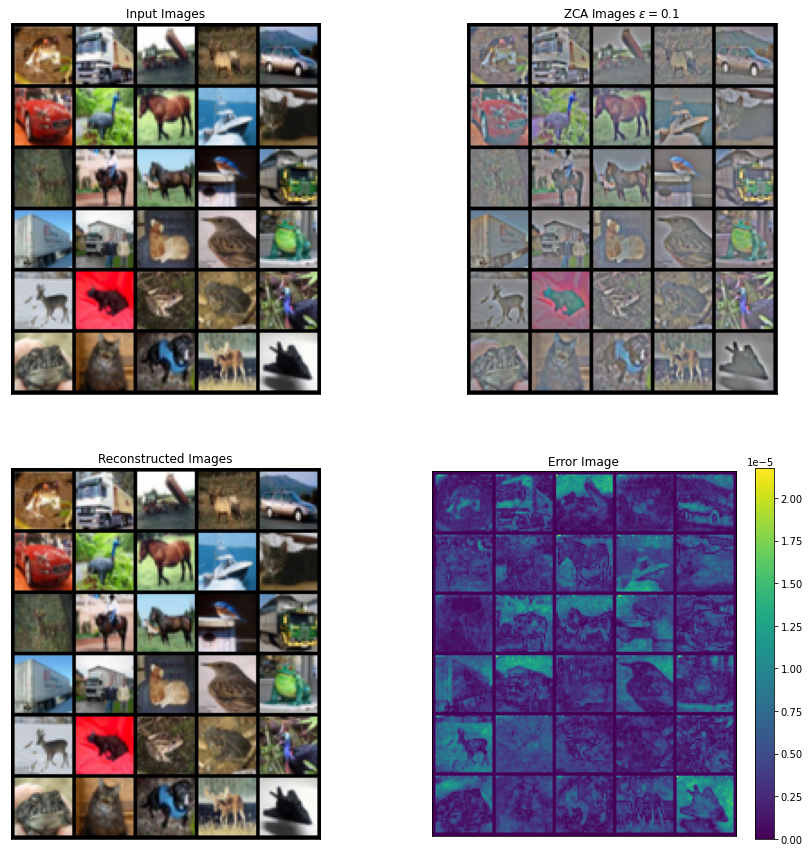

In [10]:
grid_im = make_grid(images[0:30], nrow=5, normalize=True).cpu().numpy()
grid_zca = make_grid(zca_images[0:30], nrow=5, normalize=True).cpu().numpy()
grid_re= make_grid(image_re[0:30], nrow=5, normalize=True).cpu().numpy()


err_grid= grid_re - grid_im # Compute error image

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(np.transpose(grid_im,[1,2,0]))
plt.title('Input Images')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,2)
plt.imshow(np.transpose(grid_zca,[1,2,0]))
plt.title(r'ZCA Images $\epsilon = 0.1$')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,3)
plt.imshow(np.transpose(grid_re,[1,2,0]))
plt.title(r'Reconstructed Images')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,4)
plt.imshow(np.sum(abs(np.transpose(err_grid,[1,2,0])), axis = -1))
plt.colorbar()
plt.title('Error Image')
plt.xticks([])
plt.yticks([])
plt.show()

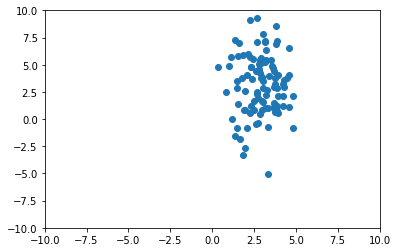

In [11]:
num_data = 100 #Number of points in the dataset
torch.manual_seed(1234)
x = torch.cat([torch.randn((num_data,1), requires_grad=True),
               3 * torch.randn((num_data,1), requires_grad=True)], dim=1) + 3

plt.scatter(x.detach().numpy()[:,0],x.detach().numpy()[:,1])
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In [12]:
zca_detach = K.enhance.ZCAWhitening(eps=1e-6, detach_transforms=True)
zca_grad = K.enhance.ZCAWhitening(eps=1e-6, detach_transforms=False)

In [13]:
import torch.autograd as autograd

J = autograd.functional.jacobian(lambda x: zca_detach(x, include_fit=True), x)

num_disp = 5
print(f'Jacobian matrices detached for the first {num_disp} points')
for i in range(num_disp):
  print(J[i,:,i,:])

print('\n')

J = autograd.functional.jacobian(lambda x: zca_grad(x, include_fit=True), x)
print(f'Jacobian matrices attached for the first {num_disp} points')
for i in range(num_disp):
  print(J[i,:,i,:])

Jacobian matrices detached for the first 5 points
tensor([[ 1.0177, -0.0018],
        [-0.0018,  0.3618]])
tensor([[ 1.0177, -0.0018],
        [-0.0018,  0.3618]])
tensor([[ 1.0177, -0.0018],
        [-0.0018,  0.3618]])
tensor([[ 1.0177, -0.0018],
        [-0.0018,  0.3618]])
tensor([[ 1.0177, -0.0018],
        [-0.0018,  0.3618]])


Jacobian matrices attached for the first 5 points
tensor([[ 1.0003, -0.0018],
        [-0.0018,  0.3547]])
tensor([[ 1.0006, -0.0027],
        [-0.0027,  0.3555]])
tensor([[ 0.9911, -0.0028],
        [-0.0028,  0.3506]])
tensor([[9.9281e-01, 4.4671e-04],
        [4.4671e-04, 3.5368e-01]])
tensor([[ 1.0072, -0.0019],
        [-0.0019,  0.3581]])


As a sanity check, the Jacobian between the input and output of the ZCA transform should be same for all data points in the detached case since the transform acts as linear transform (e.g  T(X−μ) ). In the non-detached case, the Jacobian should vary across datapoints since the input affects the computation of the ZCA transformation matrix (e.g.  T(X)(X−μ(X)) ). As the number of samples increases, the Jacobians in the detached and non-detached cases should be roughly the same since the influence of a single datapoint decreases. You can test this by changing num_data . Also note that include_fit=True is included in the forward pass since creation of the transform matrix needs to be included in the forward pass in order to correctly compute the backwards pass.

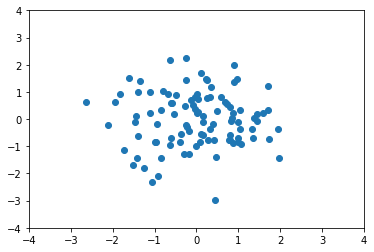

In [14]:
x_zca = zca_detach(x).detach().numpy()
plt.scatter(x_zca[:,0], x_zca[:,1])
plt.ylim([-4,4])
plt.xlim([-4,4])
plt.show()